<a href="https://colab.research.google.com/github/kaicong12/team11-datathon/blob/main/team11_datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
filepath = '/content/team11.csv'
data = pd.read_csv(filepath)

# 1. Remove Empty BMI value

In [3]:
bmi_data = pd.read_csv(filepath)
print("Rows with empty bim: ", len(bmi_data[bmi_data.bmi.isnull()]))

Rows with empty bim:  6878


# 2. Exploratory Data Analysis

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# PORTUGESE/NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER
arr = ['UNKNOWN', 'OTHER', 'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER', 'MULTIPLE RACE/ETHNICITY']
def foo(input_str):
    if 'BLACK' in input_str:
        return 'AFRICAN_AMERICAN'
    else:
        return 'NOT_BLACK'

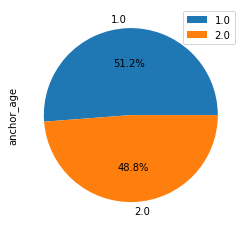

In [6]:
def bin_age(age):
    if age <= 14:
        return 0
    elif age <= 64:
        return 1
    elif age <= 89:
        return 2

new_age = data['anchor_age'].apply(bin_age)
new_age.value_counts().plot(kind="pie", autopct='%1.1f%%', legend=True)

In [7]:
"""
UNKNOWN/OTHER/UNABLE TO ATTAIN/PATIENT DECLINED TO ANSWER/MULTIPLE RACE -> OTHER
ASIAN -> ASIAN
BLACK -> AFRICAN AMERICAN
WHITE -> CAUCASIAN
HISPANIC/SOUTH AMERICAN -> LATINO
AMERICAN INDIAN -> NATIVE AMERICAN
"""
data['race_new'] = data['race'].apply(foo)

In [40]:
data['race'].value_counts()

WHITE                                        8946
UNKNOWN                                      1812
BLACK/AFRICAN AMERICAN                        978
OTHER                                         465
WHITE - OTHER EUROPEAN                        246
UNABLE TO OBTAIN                              225
ASIAN                                         197
HISPANIC/LATINO - PUERTO RICAN                174
HISPANIC OR LATINO                            124
HISPANIC/LATINO - DOMINICAN                   123
ASIAN - CHINESE                               121
WHITE - RUSSIAN                                98
PATIENT DECLINED TO ANSWER                     92
BLACK/CAPE VERDEAN                             84
BLACK/CARIBBEAN ISLAND                         70
PORTUGUESE                                     49
ASIAN - SOUTH EAST ASIAN                       47
BLACK/AFRICAN                                  44
ASIAN - ASIAN INDIAN                           39
AMERICAN INDIAN/ALASKA NATIVE                  31


## Remove top and bottom 25 quartile of BMI
## Most of the population removed are white
 

In [8]:
cols= ['bmi']
Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1

rows_removed = data[((data[cols] < (Q1 - 1.5 * IQR)) |(data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Rows to be removed from bmi ", len(rows_removed))

data = data[~((data[cols] < (Q1 - 1.5 * IQR)) |(data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
data = data[~data.bmi.isnull()].reset_index(drop=True)
print("Rows left ", len(data))

Rows to be removed from bmi  577
Rows left  14615


## Remove patients with los < 1
## Most of the patients removed are white
- CAUCASIAN             264
- OTHERS                117
- AFRICAN AMERICAN       36
- LATINO                 19
- ASIAN                  10
- NATIVE AMERICAN         1

In [9]:
rows_removed_los = len(data[data.los<1])
print("Rows to be removed from los ", rows_removed_los)

data = data[data.los>=1].reset_index(drop=True)
print("Rows left ", len(data))

Rows to be removed from los  451
Rows left  14164


In [10]:
data

,Unnamed: 0,subject_id,stay_id,height_admit,weight_admit,bmi,ventilation_status,ventilation_duration,los,sum_total_turn,daily_turn_rate,sum_total_oc,daily_oc_rate,race,insurance,sapsii_prob,gender,anchor_age,anchor_year,anchor_year_group,race_new
0,0,10001884,37510196,1.57,65.0,26.370238,InvasiveVent,412800,9.171817,105,11.448113,60,6.541779,BLACK/AFRICAN AMERICAN,Medicare,0.326364,F,68,2122,2008 - 2010,AFRICAN_AMERICAN
1,1,10002013,39060235,1.57,96.0,38.946813,InvasiveVent,25200,1.314352,11,8.369144,1,0.760831,WHITE,Medicaid,0.128048,F,53,2156,2008 - 2010,NOT_BLACK
2,4,10002527,37121704,1.60,80.1,31.289062,InvasiveVent,41160,1.438519,7,4.866117,1,0.695160,WHITE,Other,0.116839,M,50,2136,2008 - 2010,NOT_BLACK
3,5,10002760,31831386,1.85,91.0,26.588751,InvasiveVent,62640,1.045868,10,9.561436,4,3.824574,UNABLE TO OBTAIN,Other,0.152870,M,56,2141,2008 - 2010,NOT_BLACK
4,6,10003400,32128372,1.68,93.0,32.950680,InvasiveVent,30180,12.911308,143,11.075563,73,5.653959,BLACK/AFRICAN AMERICAN,Medicare,0.995367,F,72,2134,2011 - 2013,AFRICAN_AMERICAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14159,22061,19997843,32880062,1.57,70.0,28.398718,InvasiveVent,86400,2.849583,28,9.825998,17,5.965784,UNKNOWN,Other,0.096698,M,47,2120,2017 - 2019,NOT_BLACK
14160,22065,19998843,30988867,1.80,90.0,27.777778,InvasiveVent,169200,3.338646,30,8.985679,20,5.990453,UNKNOWN,Other,0.680887,M,45,2187,2011 - 2013,NOT_BLACK
14161,22066,19999287,35165301,1.65,86.2,31.662075,InvasiveVent,48000,4.705752,41,8.712741,8,1.700047,BLACK/AFRICAN AMERICAN,Medicare,0.046739,F,71,2191,2008 - 2010,AFRICAN_AMERICAN
14162,22067,19999442,32336619,1.93,107.5,28.859835,InvasiveVent,11460,6.950370,57,8.201002,30,4.316317,WHITE,Other,0.017445,M,41,2146,2008 - 2010,NOT_BLACK


In [11]:
data.to_csv('cleaned_team11.csv')

# 3. Pick out some variables for decision tree

In [12]:
cols_interest = [
    'bmi', 
    'ventilation_duration', 
    'sapsii_prob', 
    # next 3 are categorical variables to be LabelEncoded
    'enc_insurance', 
    'enc_gender', 
    'enc_race_new'
]

# 'daily_turn_rate'
target_variables = ['daily_turn_rate']

In [13]:
# label encode categorical variables
categorical_variables = [
    'insurance', 
    'gender', 
    'race_new'
]
categorical_df = pd.DataFrame()

for var in categorical_variables:
    le = LabelEncoder()
    categorical_df[f'enc_{var}'] = le.fit_transform(data[var])

In [28]:
numerical_df = data[cols_interest[:len(cols_interest)-3]]

In [15]:
# df = pd.concat([df, categorical_df, data[target_variables]], axis=1)
df = pd.concat([numerical_df, categorical_df, data[target_variables]], axis=1)
df = df.dropna()

In [16]:
train_df = df[cols_interest]
target = df[target_variables]
X_train, X_test, y_train, y_test = train_test_split(train_df, target, test_size=0.33, random_state=42)

In [17]:
X_train["enc_race_new"].value_counts()

1    8708
0     781
Name: enc_race_new, dtype: int64

In [18]:
regressor = DecisionTreeRegressor(random_state=0)
# regressor.fit(X_train, y_train)

# prediction = regressor.predict(X_test)
# mean_squared_error(prediction, y_test)
cross_val_score(regressor, train_df, target, cv=10, scoring='neg_mean_squared_error')

array([-8.67032375, -8.39762092, -8.76274557, -7.91609058, -8.67812018,
       -8.19157114, -8.49047133, -8.8905223 , -9.34795346, -7.9273429 ])

In [19]:
import numpy as np

# RMSE larger than mean of prediction, bad prediction
np.mean(y_test)

daily_turn_rate    9.451794
dtype: float64

# 4. Try Linear Regression

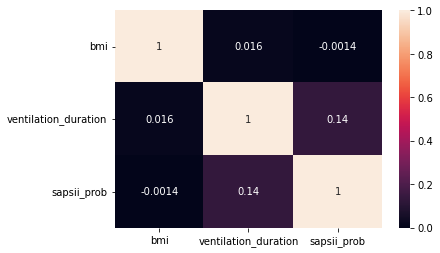

In [20]:
import seaborn as sns

corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True)

In [24]:
import statsmodels.formula.api as sm

ols_cols = cols_interest = [
    'bmi', 
    'ventilation_duration', 
    'sapsii_prob', 
    'anchor_age',
    # next 3 are categorical variables to be LabelEncoded
    'insurance', 
    'gender', 
    'race_new',
    'sum_total_turn'
]

ols_df = data[ols_cols].dropna()


def enc_bmi(bmi):
    if bmi <= 25:
        return 'Normal'
    elif bmi <= 30:
        return 'Overweight'
    elif bmi <= 35:
        return 'Obese'
    else:
        return 'Morbidly Obese'

ols_df['enc_bmi'] = ols_df['bmi'].apply(enc_bmi)

In [25]:
ols_df 

,bmi,ventilation_duration,sapsii_prob,anchor_age,insurance,gender,race_new,sum_total_turn,enc_bmi
0,26.370238,412800,0.326364,68,Medicare,F,AFRICAN_AMERICAN,105,Overweight
1,38.946813,25200,0.128048,53,Medicaid,F,NOT_BLACK,11,Morbidly Obese
2,31.289062,41160,0.116839,50,Other,M,NOT_BLACK,7,Obese
3,26.588751,62640,0.152870,56,Other,M,NOT_BLACK,10,Overweight
4,32.950680,30180,0.995367,72,Medicare,F,AFRICAN_AMERICAN,143,Obese
...,...,...,...,...,...,...,...,...,...
14159,28.398718,86400,0.096698,47,Other,M,NOT_BLACK,28,Overweight
14160,27.777778,169200,0.680887,45,Other,M,NOT_BLACK,30,Overweight
14161,31.662075,48000,0.046739,71,Medicare,F,AFRICAN_AMERICAN,41,Obese
14162,28.859835,11460,0.017445,41,Other,M,NOT_BLACK,57,Overweight


In [41]:
df = pd.read_csv('cleaned_team11.csv')
list1 = ['anchor_age', 'race_new', 'bmi', 'sapsii_prob', 'gender', 'insurance']
target = ['daily_oc_rate']

x = df[list1]
y = df[target]
model2 = sm.ols('daily_oc_rate ~ race_new', data=df).fit()
# print(model1.summary())
print(model2.summary2())

                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.004     
Dependent Variable:   daily_oc_rate    AIC:                61823.8169
Date:                 2022-12-04 07:51 BIC:                61838.9338
No. Observations:     14164            Log-Likelihood:     -30910.   
Df Model:             1                F-statistic:        60.67     
Df Residuals:         14162            Prob (F-statistic): 7.21e-15  
R-squared:            0.004            Scale:              4.6036    
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept              4.6815   0.0626 74.8242 0.0000  4.5589  4.8042
race_new[T.NOT_BLACK] -0.5089   0.0653 -7.7892 0.0000 -0.6370 -0.3809
---------------------------------------------------------------------
Omnibus:               2095.769       D

In [42]:
df = pd.read_csv('cleaned_team11.csv')
list1 = ['anchor_age', 'race_new', 'bmi', 'sapsii_prob', 'gender', 'insurance']
target = ['daily_oc_rate']

x = df[list1]
y = df[target]
model2 = sm.ols('daily_oc_rate ~ race_new + insurance + gender', data=df).fit()
# print(model1.summary())
print(model2.summary2())

                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.012     
Dependent Variable:   daily_oc_rate    AIC:                61713.6962
Date:                 2022-12-04 07:51 BIC:                61751.4885
No. Observations:     14164            Log-Likelihood:     -30852.   
Df Model:             4                F-statistic:        44.43     
Df Residuals:         14159            Prob (F-statistic): 3.96e-37  
R-squared:            0.012            Scale:              4.5670    
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept              5.1598   0.0881 58.5424 0.0000  4.9871  5.3326
race_new[T.NOT_BLACK] -0.4443   0.0654 -6.7899 0.0000 -0.5726 -0.3160
insurance[T.Medicare] -0.3099   0.0715 -4.3360 0.0000 -0.4500 -0.1698
insurance[T.Other]    -0.4584   0.0713 

In [43]:
df = pd.read_csv('cleaned_team11.csv')
list1 = ['anchor_age', 'race_new', 'bmi', 'sapsii_prob', 'gender', 'insurance']
target = ['daily_oc_rate']

x = df[list1]
y = df[target]
model2 = sm.ols('daily_oc_rate ~ race_new + insurance + gender + bmi + sapsii_prob', data=df).fit()
# print(model1.summary())
print(model2.summary2())

                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.037     
Dependent Variable:   daily_oc_rate    AIC:                61355.9347
Date:                 2022-12-04 07:51 BIC:                61408.8439
No. Observations:     14164            Log-Likelihood:     -30671.   
Df Model:             6                F-statistic:        91.42     
Df Residuals:         14157            Prob (F-statistic): 4.83e-113 
R-squared:            0.037            Scale:              4.4524    
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept              5.0330   0.1217 41.3498 0.0000  4.7944  5.2715
race_new[T.NOT_BLACK] -0.4286   0.0646 -6.6323 0.0000 -0.5552 -0.3019
insurance[T.Medicare] -0.4870   0.0712 -6.8405 0.0000 -0.6265 -0.3474
insurance[T.Other]    -0.5200   0.0705 